### Imports

In [1]:
import json
from pprint import pprint
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates
import matplotlib.pyplot as plt

### Part 1: generic code

In [2]:
def get_value(result: BinaryClassificationResult):
    return result.acc()

In [3]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results(all_results):
    total_results = BinaryClassificationResult()
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_results in enumerate(configuration_results):
            if isinstance(run_results, list):  # This means that the experiment was federated
                # In that case we just look at the last results
                total_results += BinaryClassificationResult(*run_results[-1].values())
            else:
                total_results += BinaryClassificationResult(*run_results.values())
            
    return total_results

### Part 2: grid search results

In [4]:
# Get the results of a single configuration, for a single experiment, summed over the reruns
# out of the results for every device in the right order
def get_combined_results(all_devices_experiment_results, clients_devices):
    results = BinaryClassificationResult()
    for run, run_results in enumerate(all_devices_experiment_results):
        # We need a configuration that tested all devices in order to be able to reconstruct the results
        assert(len(run_results) == 9)
        for device_id, device_results in enumerate(run_results):
            if [device_id] in clients_devices:
                results += BinaryClassificationResult(*device_results.values())
                
    return results

In [5]:
path_gs = 'grid_search_results/multiple_classifiers/run_26/'

In [6]:
with open(path_gs + 'local_results.json') as json_file:
    gs_local_results = json.load(json_file)

In [7]:
for clients_devices, config_results in gs_local_results.items():
    print(clients_devices)
    for hparams, config_exp_results in config_results.items():
        print(hparams)
        result = BinaryClassificationResult(*config_exp_results.values())
        print_rates(result)
        print(get_value(result))
        
    print()

[[0], [1], [2], [3], [4], [5], [6], [7]]
{'normalization': '0-mean 1-var', 'optimizer_params': {'lr': 1.0, 'weight_decay': 1e-05}}
TPR: 0.53361 - TNR: 0.50510 - Accuracy: 0.53115 - Recall: 0.53361 - Precision: 0.91941 - F1-Score: 0.67530
0.5311522781762363
{'normalization': '0-mean 1-var', 'optimizer_params': {'lr': 1.0, 'weight_decay': 5e-05}}
TPR: 0.48179 - TNR: 0.50621 - Accuracy: 0.48390 - Recall: 0.48179 - Precision: 0.91169 - F1-Score: 0.63043
0.48390038525770285
{'normalization': 'min-max', 'optimizer_params': {'lr': 1.0, 'weight_decay': 1e-05}}
TPR: 0.79094 - TNR: 0.27550 - Accuracy: 0.74643 - Recall: 0.79094 - Precision: 0.92032 - F1-Score: 0.85074
0.7464319593731946
{'normalization': 'min-max', 'optimizer_params': {'lr': 1.0, 'weight_decay': 5e-05}}
TPR: 0.50529 - TNR: 0.63202 - Accuracy: 0.51623 - Recall: 0.50529 - Precision: 0.93560 - F1-Score: 0.65619
0.5162341135965095

[[0], [1], [2], [3], [4], [5], [6], [8]]
{'normalization': '0-mean 1-var', 'optimizer_params': {'lr': 1

### Part 2: test results analysis

In [8]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [9]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [10]:
def plot_federated_acc(results_to_plot, title=''):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_xlabel('Federation round')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    plt.show()

In [11]:
path_test = 'test_results/federated_classifiers/run_0/'

In [12]:
with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)

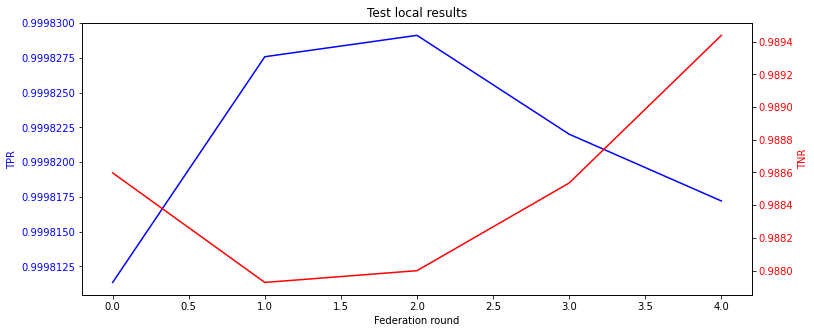

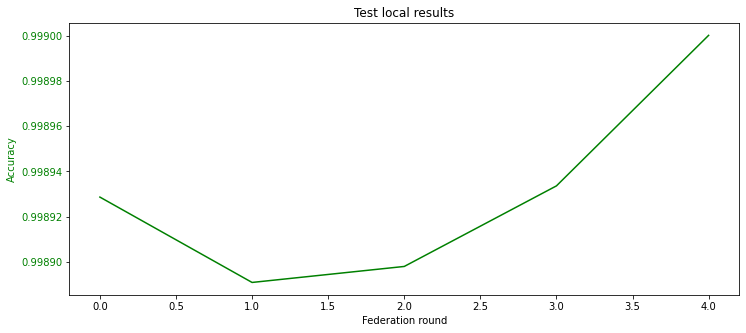

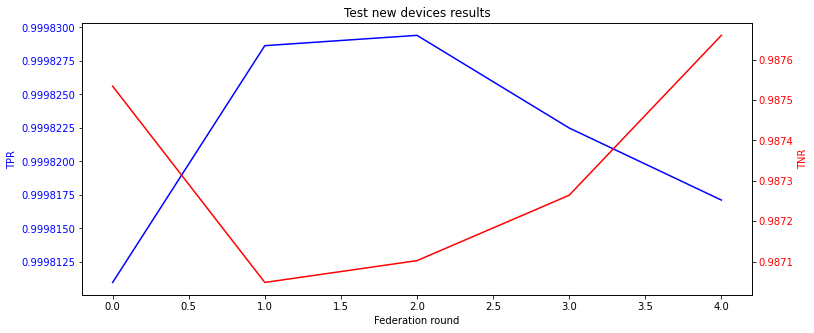

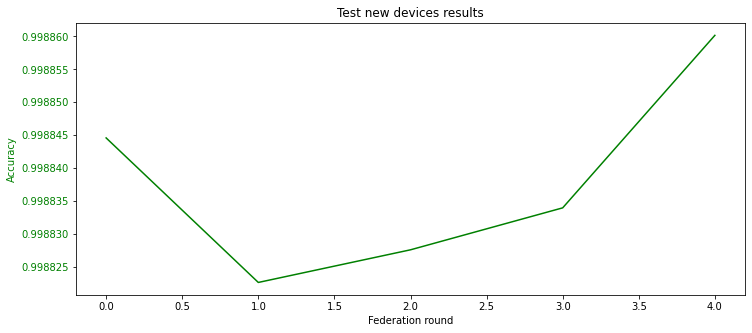

In [13]:
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results')

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

These plots are interesting but could be improved with: confidence intervals, more federation rounds, agreeing on a metric that takes into account the importance of tnr vs tpr, doing the same on new devices results.

### Part 3: grid search results analysis

In [14]:
def get_params_to_results(all_results):
    params_to_results = {}
    for params, experiment_results in all_results.items():
        params_to_results[params] = get_results(experiment_results)

    return params_to_results

In [15]:
path_gs = 'grid_search_results/multiple_classifiers/run_0/'

with open(path_gs + 'local_results.json') as json_file:
    gs_local_results = json.load(json_file)
    
with open(path_gs + 'new_devices_results.json') as json_file:
    gs_new_results = json.load(json_file)

In [16]:
gs_local_params_to_results = get_params_to_results(gs_local_results)
gs_new_params_to_results = get_params_to_results(gs_new_results)

print('LOCAL RESULTS')
for params, result in gs_local_params_to_results.items():
    print(params)
    print_rates(result)
    print()
print()

print('NEW RESULTS')
for params, result in gs_new_params_to_results.items():
    print(params)
    print_rates(result)
    print()

LOCAL RESULTS
{'normalization': '0-mean 1-var', 'optimizer_params': {'lr': 1.0, 'weight_decay': 1e-05}}
TPR: 0.99981 - TNR: 0.99553 - Accuracy: 0.99948 - Recall: 0.99981 - Precision: 0.99962 - F1-Score: 0.99972

{'normalization': '0-mean 1-var', 'optimizer_params': {'lr': 1.0, 'weight_decay': 5e-05}}
TPR: 0.99980 - TNR: 0.99514 - Accuracy: 0.99943 - Recall: 0.99980 - Precision: 0.99958 - F1-Score: 0.99969

{'normalization': 'min-max', 'optimizer_params': {'lr': 1.0, 'weight_decay': 1e-05}}
TPR: 0.99973 - TNR: 0.99531 - Accuracy: 0.99939 - Recall: 0.99973 - Precision: 0.99960 - F1-Score: 0.99967

{'normalization': 'min-max', 'optimizer_params': {'lr': 1.0, 'weight_decay': 5e-05}}
TPR: 0.99973 - TNR: 0.99501 - Accuracy: 0.99936 - Recall: 0.99973 - Precision: 0.99957 - F1-Score: 0.99965


NEW RESULTS
{'normalization': '0-mean 1-var', 'optimizer_params': {'lr': 1.0, 'weight_decay': 1e-05}}
TPR: 0.97580 - TNR: 0.80574 - Accuracy: 0.96241 - Recall: 0.97580 - Precision: 0.98328 - F1-Score: 0.

We can see that min-max normalization works much better. However we need to make that decision automatic based on a function of TPR local, TNR local, TPR new, TNR new.